In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core and utils directory 
from algorithms import OnlineMA, OnlineMAPred, OnlineMC, OnlineMCAdaptiveEfficient
from utils import rolling_mean, rolling_vec_norm

In [2]:
# Output directory for plots
plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

In [3]:
# Plotting 
sns.set_style('whitegrid', {'grid.linestyle': '-', 'grid.alpha': 0.4})
sns.set_context('poster')

color_dict = {
    'adaptive':                  'tab:green',
    'non-adaptive':              'tab:red',
    'ptilde':                    'tab:blue',
    'ma':                        'tab:purple',
    'maonly_na':                 'tab:pink',
    'mapred_na':                 'tab:red',
    'mapred':                    'tab:green',
    'mc_na':                     'tab:orange',
    'mc_adaptive':               'tab:brown',
}

plt.rcParams.update({
    'font.size': 28,
    'axes.titlesize': 28,
    'axes.labelsize': 28,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'figure.autolayout': False, 
})

In [ ]:
def simulate_jump_drift(
    T=6000,
    d=5,
    noise_std=1.0,
    beta_scale=1.0,
    small_levels=None,      
    big_levels=None,        
    small_block=200,
    big_block=400,
    T_base=None,
    rng=None,
):
    """
    Jump shifts:
      - Three segments (T/3 each).
      - Segments 1 & 3: small oscillations over `small_levels`.
      - Segment 2: larger oscillations over `big_levels`.
    """
    rng = np.random.default_rng(rng)

    X = rng.normal(0.0, 1.0, size=(T, d))

    # Initial beta_0 and direction
    beta0 = rng.normal(0.0, beta_scale, size=d) / np.sqrt(d)
    direction = rng.normal(0.0, 1.0, size=d)
    direction /= np.linalg.norm(direction) + 1e-12

    # defaults for levels if not provided
    if small_levels is None:
        small_levels = np.linspace(-0.05, 0.05, 3)      
    if big_levels is None:
        big_levels = np.array([-0.5, 0.5])              

    mu = np.zeros(T)
    T1 = T // 3
    T2 = 2 * T // 3

    # segment 1: small oscillations
    idx = 0
    for t in range(0, T1):
        if t > 0 and t % small_block == 0:
            idx = (idx + 1) % len(small_levels)
        mu[t] = small_levels[idx]

    # segment 2: big oscillations
    idx = 0
    for t in range(T1, T2):
        if t > T1 and (t - T1) % big_block == 0:
            idx = (idx + 1) % len(big_levels)
        mu[t] = big_levels[idx]

    # segment 3: small oscillations
    idx = 0
    for t in range(T2, T):
        if t > T2 and (t - T2) % small_block == 0:
            idx = (idx + 1) % len(small_levels)
        mu[t] = small_levels[idx]

    # Map μ_t to β_t
    betas = beta0[None, :] + mu[:, None] * direction[None, :]

    # Outcomes
    noise = rng.normal(0.0, noise_std, size=T)
    y = (X * betas).sum(axis=1) + noise

    # f_j(X) = X_j
    G = X.copy()

    if T_base is None:
        T_base = T

    X_base = rng.normal(0.0, 1.0, size=(T_base, d))
    beta_base = beta0.copy()
    noise_base = rng.normal(0.0, noise_std, size=T_base)
    y_base = X_base @ beta_base + noise_base

    lam = 1e-3
    XtX = X_base.T @ X_base + lam * np.eye(d)
    Xty = X_base.T @ y_base
    beta_hat = np.linalg.solve(XtX, Xty)

    p_tilde = X @ beta_hat

    return X, y, G, betas, p_tilde, mu

def generate_jump_variants(T=6000, d=5, rng=0):
    rng = np.random.default_rng(rng)

    variants = {}

    # 1) Small shifts
    variants["jump_small"] = simulate_jump_drift(
        T=T,
        d=d,
        small_levels=np.linspace(-0.05, 0.05, 5),
        big_levels=np.array([-0.5, 0.5]),
        small_block=200,
        big_block=400,
        rng=rng,
    )

    # 2) Medium shifts
    variants["jump_medium"] = simulate_jump_drift(
        T=T,
        d=d,
        small_levels=np.linspace(-0.075, 0.075, 5),
        big_levels=np.array([-1.0, 1.0]),
        small_block=200,
        big_block=400,
        rng=rng,
    )

    # 3) Large shifts
    variants["jump_large"] = simulate_jump_drift(
        T=T,
        d=d,
        small_levels=np.linspace(-0.1, 0.1, 5),
        big_levels=np.array([-1.5, 1.5]),
        small_block=200,
        big_block=400,
        rng=rng,
    )

    return variants



In [5]:
def plot_jump_mus(variants):
    """
    variants: dict from generate_jump_variants
      key -> (X, y, G, betas, p_tilde, mu)
    Plots μ_t for jump_small, jump_medium, jump_large.
    """
    names = ["jump_small", "jump_medium", "jump_large"]
    titles = ["Small jumps", "Medium jumps", "Large jumps"]

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True)

    T = len(variants[names[0]][5])
    T1 = T // 3
    T2 = 2 * T // 3

    for ax, name, title in zip(axes, names, titles):
        _, _, _, _, _, mu = variants[name]
        t = np.arange(len(mu))
        ax.plot(t, mu, linewidth=3.5)
        ax.set_title(title)
        ax.tick_params(axis="x", rotation=35)
        ax.set_xlabel("Time")

        # show regime boundaries
        ax.axvline(T1, linestyle="--", alpha=0.4)
        ax.axvline(T2, linestyle="--", alpha=0.4)

    axes[0].set_ylabel(r"$\mu_t$", fontsize=32)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "jump_mus.pdf"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_jump_betas(variants, coord=0):
    """
    variants: dict from generate_jump_variants
      key -> (X, y, G, betas, p_tilde, mu)

    Plots β_{t,coord} for jump_small, jump_medium, jump_large.
    coord: which coordinate of β_t to plot.
    """
    names  = ["jump_small", "jump_medium", "jump_large"]
    titles = ["Small jumps", "Medium jumps", "Large jumps"]

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharex=True, sharey=True)

    T  = variants[names[0]][3].shape[0]   # betas is index 3
    T1 = T // 3
    T2 = 2 * T // 3

    for ax, name, title in zip(axes, names, titles):
        _, _, _, betas, _, _ = variants[name]
        beta_coord = betas[:, coord]
        t = np.arange(len(beta_coord))

        ax.plot(t, beta_coord, linewidth=3.5)
        ax.set_title(title)
        ax.tick_params(axis="x", rotation=35)
        ax.set_xlabel("Time")

        # regime boundaries
        ax.axvline(T1, linestyle="--", alpha=0.4)
        ax.axvline(T2, linestyle="--", alpha=0.4)

    axes[0].set_ylabel(rf"$\beta_{{t,{coord}}}$", fontsize=32)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f"jump_betas_{coord}.pdf"), dpi=300, bbox_inches="tight")
    plt.show()

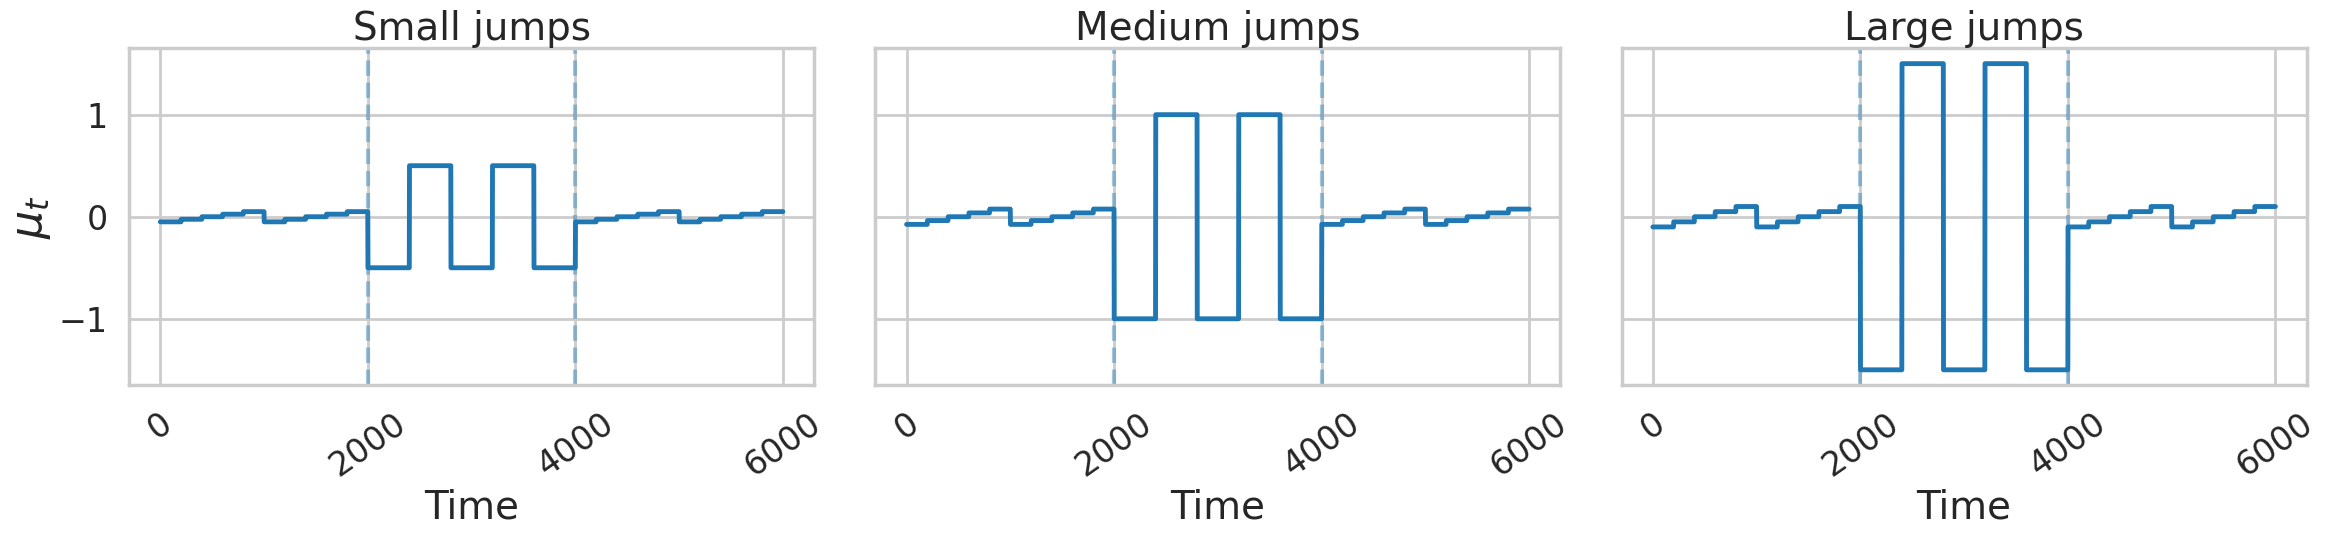

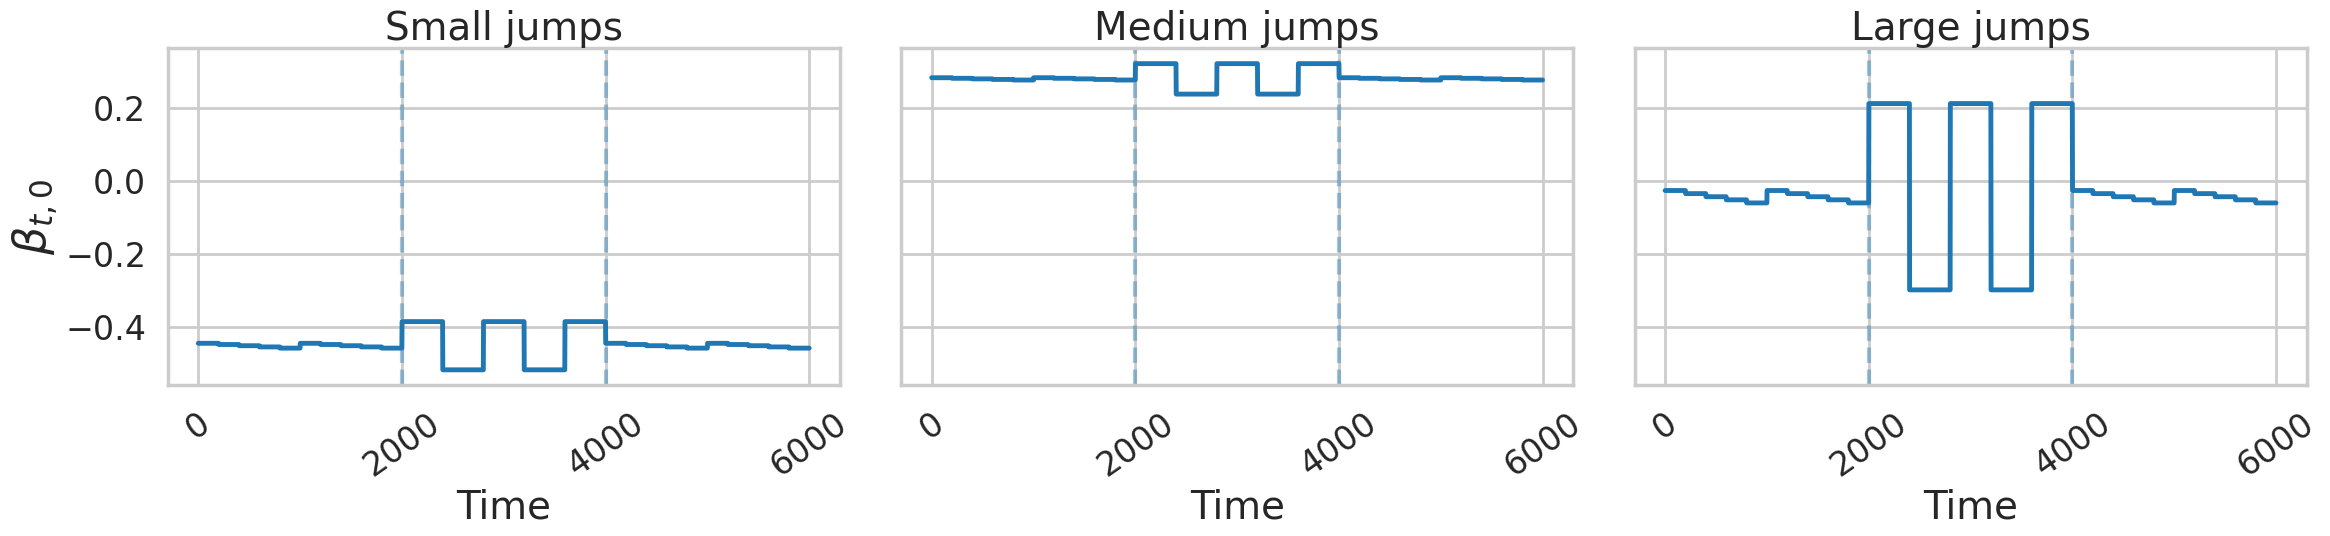

In [6]:
variants = generate_jump_variants(T=6000, d=5, rng=42)

X_small, y_small, G_small, betas_small, ptilde_small, mu_small = variants["jump_small"]
X_med,   y_med,   G_med,   betas_med,   ptilde_med,   mu_med   = variants["jump_medium"]
X_large, y_large, G_large, betas_large, ptilde_large, mu_large = variants["jump_large"]

plot_jump_mus(variants)
plot_jump_betas(variants, coord=0)

In [ ]:
window = 200
window_plot = 200
eta = 0.5
loss = "squared" 

variant_names = ["jump_small", "jump_medium", "jump_large"]

results = {}  # variant_name -> dict of arrays

for vname in variant_names:
    X, y_all, G, betas, p_tilde, mu = variants[vname]
    T, d = X.shape
    m = G.shape[1]
    num_groups = G.shape[1]

    # Online learners 
    maonly = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
    maonly_nonadaptive = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
    mapred = OnlineMAPred(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
    mapred_nonadaptive = OnlineMAPred(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
    mc = OnlineMC(n=10, r=1000, m=num_groups, num_time_steps=T, window_size=window, adaptive=True)
    mc_nonadaptive = OnlineMC(n=10, r=1000, m=num_groups, num_time_steps=T, window_size=window, adaptive=False)
    mc_adaptive = OnlineMCAdaptiveEfficient(n=10, r=1000, m=num_groups, eta=eta, num_time_steps=T)

    # Track metrics
    ptilde_baseline_ma_losses = [] 
    maonly_baseline_ma_losses, maonly_baseline_lpred = [], []
    maonly_nonadaptive_ma_losses, maonly_nonadaptive_lpred = [], []
    mapred_ma_losses, mapred_l_pred = [], []
    mapred_nonadaptive_ma_losses, mapred_nonadaptive_l_pred = [], []
    mc_ma_losses, mc_l_pred = [], []
    mc_nonadaptive_ma_losses, mc_nonadaptive_l_pred = [], []
    mc_adaptive_ma_losses, mc_adaptive_l_pred = [], []

    for t in tqdm(range(T)):
        x_t = X[t]                  # (1,)
        y_t_scalar = float(y_all[t])
        g_t = G[t]                  # (m,)
        pt_t = float(p_tilde[t])

        # Baseline from p̃: MA vector at step t
        vec_ptilde_t = g_t * (y_t_scalar - pt_t)   # (m,)
        ptilde_baseline_ma_losses.append(np.concatenate([vec_ptilde_t, -vec_ptilde_t]))

        # Baseline: MA-only baseline (no predret term)
        metrics = maonly.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        maonly_baseline_ma_losses.append(metrics["ma_losses"])  
        maonly_baseline_lpred.append(metrics["l_pred"])           

        # Baseline: Non-adaptive MA-only
        metrics = maonly_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        maonly_nonadaptive_ma_losses.append(metrics["ma_losses"])  
        maonly_nonadaptive_lpred.append(metrics["l_pred"])           

        # Baseline: Non-adaptive MA+pred
        metrics = mapred_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        mapred_nonadaptive_ma_losses.append(metrics["ma_losses"])   
        mapred_nonadaptive_l_pred.append(metrics["l_pred"])           

        # Locally adaptive MA+pred with external p̃
        metrics = mapred.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        mapred_ma_losses.append(metrics["ma_losses"])               
        mapred_l_pred.append(metrics["l_pred"])  
        
        # Model update: Non-adaptive MC
        metrics = mc_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        mc_nonadaptive_ma_losses.append(metrics["ma_losses"])
        mc_nonadaptive_l_pred.append(metrics["l_pred"])

        # # Model update: Locally adaptive MC
        metrics = mc.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        mc_ma_losses.append(metrics["ma_losses"])
        mc_l_pred.append(metrics["l_pred"])

        # Model update: Adaptive MC
        metrics = mc_adaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
        mc_adaptive_ma_losses.append(metrics["ma_losses"])
        mc_adaptive_l_pred.append(metrics["l_pred"])

    results[vname] = {
        "ptilde_baseline_ma_losses": ptilde_baseline_ma_losses,  # list of (2m,) arrays

        "maonly_ma_losses": maonly_baseline_ma_losses,           # list of (m,) arrays
        "maonly_l_pred": maonly_baseline_lpred,                  # list of floats

        "maonly_nonadaptive_ma_losses": maonly_nonadaptive_ma_losses,
        "maonly_nonadaptive_l_pred": maonly_nonadaptive_lpred,

        "mapred_ma_losses": mapred_ma_losses,
        "mapred_l_pred": mapred_l_pred,

        "mapred_nonadaptive_ma_losses": mapred_nonadaptive_ma_losses,
        "mapred_nonadaptive_l_pred": mapred_nonadaptive_l_pred,

        "mc_ma_losses": mc_ma_losses,
        "mc_l_pred": mc_l_pred,

        "mc_nonadaptive_ma_losses": mc_nonadaptive_ma_losses,
        "mc_nonadaptive_l_pred": mc_nonadaptive_l_pred, 

        "mc_adaptive_ma_losses": mc_adaptive_ma_losses,
        "mc_adaptive_l_pred": mc_adaptive_l_pred,
        
    }
    

100%|██████████| 6000/6000 [48:40<00:00,  2.05it/s]  


In [10]:
metrics = {}  # vname -> dict of smoothed series

window_plot = 200

for vname, res in results.items():
    # unpack raw per-round arrays
    ptilde_baseline_ma_losses      = res["ptilde_baseline_ma_losses"]
    maonly_baseline_ma_losses      = res["maonly_ma_losses"]
    maonly_baseline_lpred          = res["maonly_l_pred"]
    maonly_nonadaptive_ma_losses   = res["maonly_nonadaptive_ma_losses"]
    maonly_nonadaptive_lpred       = res["maonly_nonadaptive_l_pred"]
    mapred_ma_losses               = res["mapred_ma_losses"]
    mapred_l_pred                  = res["mapred_l_pred"]
    mapred_nonadaptive_ma_losses   = res["mapred_nonadaptive_ma_losses"]
    mapred_nonadaptive_l_pred      = res["mapred_nonadaptive_l_pred"]
    mc_ma_losses                   = res["mc_ma_losses"]
    mc_l_pred                      = res["mc_l_pred"]
    mc_nonadaptive_ma_losses       = res["mc_nonadaptive_ma_losses"]
    mc_nonadaptive_l_pred          = res["mc_nonadaptive_l_pred"]
    mc_adaptive_ma_losses          = res["mc_adaptive_ma_losses"]
    mc_adaptive_l_pred             = res["mc_adaptive_l_pred"]

    ptilde_baseline_ma_l2 = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l2")
    ptilde_baseline_ma_linf = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l_infty")

    maonly_baseline_ma_l2 = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l2")
    maonly_baseline_ma_linf = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l_infty")
    maonly_baseline_lpred = rolling_mean(maonly_baseline_lpred, window_plot)

    maonly_nonadaptive_ma_l2 = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l2")
    maonly_nonadaptive_ma_linf = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l_infty")
    maonly_nonadaptive_lpred = rolling_mean(maonly_nonadaptive_lpred, window_plot)

    mapred_nonadaptive_ma_l2 = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l2")
    mapred_nonadaptive_ma_linf = rolling_vec_norm(mapred_nonadaptive_ma_losses, window_plot, norm="l_infty")
    mapred_nonadaptive_l_pred = rolling_mean(mapred_nonadaptive_l_pred, window_plot)

    mapred_ma_l2 = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l2")
    mapred_ma_linf = rolling_vec_norm(mapred_ma_losses, window_plot, norm="l_infty")
    mapred_lpred = rolling_mean(mapred_l_pred, window_plot)

    mc_nonadaptive_ma_l2 = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot, norm="l2")
    mc_nonadaptive_ma_linf = rolling_vec_norm(mc_nonadaptive_ma_losses, window_plot, norm="l_infty")
    mc_nonadaptive_l_pred = rolling_mean(mc_nonadaptive_l_pred, window_plot)

    mc_ma_l2 = rolling_vec_norm(mc_ma_losses, window_plot, norm="l2")
    mc_ma_linf = rolling_vec_norm(mc_ma_losses, window_plot, norm="l_infty")
    mc_l_pred = rolling_mean(mc_l_pred, window_plot)

    mc_adaptive_ma_l2 = rolling_vec_norm(mc_adaptive_ma_losses, window_plot, norm="l2")
    mc_adaptive_ma_linf = rolling_vec_norm(mc_adaptive_ma_losses, window_plot, norm="l_infty")
    mc_adaptive_l_pred = rolling_mean(mc_adaptive_l_pred, window_plot)

    metrics[vname] = {
        "ptilde_ma_l2": ptilde_baseline_ma_l2,
        "ptilde_ma_linf": ptilde_baseline_ma_linf,

        "maonly_ma_l2": maonly_baseline_ma_l2,
        "maonly_ma_linf": maonly_baseline_ma_linf,
        "maonly_lpred": maonly_baseline_lpred,

        "maonly_nonadaptive_ma_l2": maonly_nonadaptive_ma_l2,
        "maonly_nonadaptive_ma_linf": maonly_nonadaptive_ma_linf,
        "maonly_nonadaptive_lpred": maonly_nonadaptive_lpred,

        "mapred_nonadaptive_ma_l2": mapred_nonadaptive_ma_l2,
        "mapred_nonadaptive_ma_linf": mapred_nonadaptive_ma_linf,
        "mapred_nonadaptive_lpred": mapred_nonadaptive_l_pred,

        "mapred_ma_l2": mapred_ma_l2,
        "mapred_ma_linf": mapred_ma_linf,
        "mapred_lpred": mapred_lpred,

        "mc_nonadaptive_ma_l2": mc_nonadaptive_ma_l2,
        "mc_nonadaptive_ma_linf": mc_nonadaptive_ma_linf,
        "mc_nonadaptive_l_pred": mc_nonadaptive_l_pred,

        "mc_ma_l2": mc_ma_l2,
        "mc_ma_linf": mc_ma_linf,
        "mc_l_pred": mc_l_pred,

        "mc_adaptive_ma_l2": mc_adaptive_ma_l2,
        "mc_adaptive_ma_linf": mc_adaptive_ma_linf,
        "mc_adaptive_l_pred": mc_adaptive_l_pred,
    }

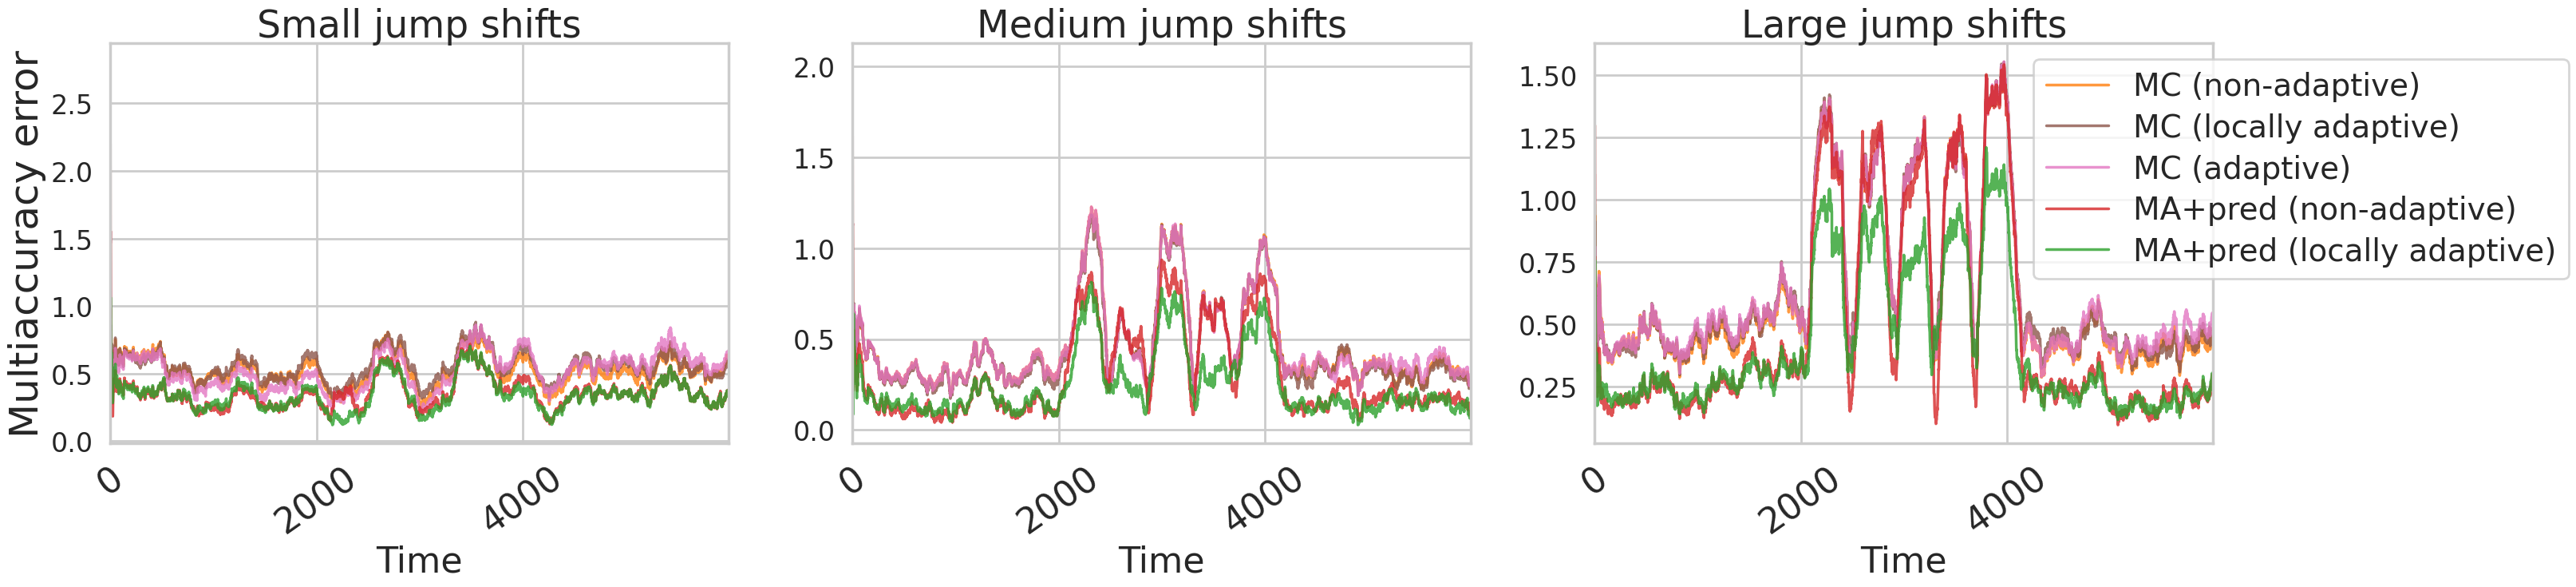

In [13]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import os

# colors as before
color_dict = {
    'ptilde':               'tab:blue',
    'ma':                   'tab:purple',
    'mc_na':                'tab:orange',
    'mc_locally_adaptive':  'tab:brown',
    'mc_weakly_adaptive':   'tab:pink',
    'mapred_na':            'tab:red',
    'mapred':               'tab:green',
}

small_series_to_plot = [
    (metrics["jump_small"]["mc_nonadaptive_ma_linf"],     r"MC (non-adaptive)",           "mc_na"),
    (metrics["jump_small"]["mc_ma_linf"],                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (metrics["jump_small"]["mc_adaptive_ma_linf"],        r"MC (adaptive)",               "mc_weakly_adaptive"),
    (metrics["jump_small"]["mapred_nonadaptive_ma_linf"], r"MA+pred (non-adaptive)",      "mapred_na"),
    (metrics["jump_small"]["mapred_ma_linf"],             r"MA+pred (locally adaptive)",  "mapred"),
]

mid_series_to_plot = [
    (metrics["jump_medium"]["mc_nonadaptive_ma_linf"],     r"MC (non-adaptive)",           "mc_na"),
    (metrics["jump_medium"]["mc_ma_linf"],                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (metrics["jump_medium"]["mc_adaptive_ma_linf"],        r"MC (adaptive)",               "mc_weakly_adaptive"),
    (metrics["jump_medium"]["mapred_nonadaptive_ma_linf"], r"MA+pred (non-adaptive)",      "mapred_na"),
    (metrics["jump_medium"]["mapred_ma_linf"],             r"MA+pred (locally adaptive)",  "mapred"),
]

large_series_to_plot = [
    (metrics["jump_large"]["mc_nonadaptive_ma_linf"],     r"MC (non-adaptive)",           "mc_na"),
    (metrics["jump_large"]["mc_ma_linf"],                 r"MC (locally adaptive)",       "mc_locally_adaptive"),
    (metrics["jump_large"]["mc_adaptive_ma_linf"],        r"MC (adaptive)",               "mc_weakly_adaptive"),
    (metrics["jump_large"]["mapred_nonadaptive_ma_linf"], r"MA+pred (non-adaptive)",      "mapred_na"),
    (metrics["jump_large"]["mapred_ma_linf"],             r"MA+pred (locally adaptive)",  "mapred"),
]

series_to_plot = mid_series_to_plot

fig, axes = plt.subplots(1, 3, figsize=(34, 6.5), sharex=False)
ax_small, ax_mid, ax_large = axes

LEFT_SKIP = 0
T_left = max(len(y) for y, _, _ in series_to_plot if y is not None)
x_left = np.arange(T_left)[LEFT_SKIP:]

# LEFT: small jumps
for y, label, group in small_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_small.plot(x_left, yy[LEFT_SKIP:],label=label, color=color_dict.get(group, "0.3"),linewidth=2.5, alpha=0.8, )
ax_small.set_xlim(x_left[0], x_left[-1])
ax_small.set_title("Small jump shifts", fontsize=34)
ax_small.set_xlabel("Time", fontsize=32)
ax_small.set_ylabel("Multiaccuracy error", fontsize=36)
ax_small.tick_params(axis="x", rotation=35, labelsize=32)
ax_small.grid(True)

# MIDDLE: medium jumps
for y, label, group in mid_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_mid.plot(x_left, yy[LEFT_SKIP:], label=label, color=color_dict.get(group, "0.3"), linewidth=2.5, alpha=0.8,)
ax_mid.set_xlim(x_left[0], x_left[-1])
ax_mid.set_title("Medium jump shifts", fontsize=34)
ax_mid.set_xlabel("Time", fontsize=32)
ax_mid.tick_params(axis="x", rotation=35, labelsize=32)
ax_mid.grid(True)

# RIGHT: large jumps
for y, label, group in large_series_to_plot:
    if y is None:
        continue
    yy = np.asarray(y)
    ax_large.plot(x_left, yy[LEFT_SKIP:], label=label, color=color_dict.get(group, "0.3"), linewidth=2.5, alpha=0.8,)
ax_large.set_xlim(x_left[0], x_left[-1])
ax_large.set_title("Large jump shifts", fontsize=34)
ax_large.set_xlabel("Time", fontsize=32)
ax_large.tick_params(axis="x", rotation=35, labelsize=32)
ax_large.grid(True)

# legend on the right
ax_large.legend(
    loc="upper right",
    bbox_to_anchor=(1.6, 1),
    ncol=1,
    fontsize=28,
    labelspacing=0.35,
)

plt.savefig(os.path.join(plots_dir, "jump_multiaccuracy_shift_variants.pdf"),dpi=300, bbox_inches="tight")
plt.show()